# Does smoking affect your hospital bills?

Let us use the dataset from [Kaggle](https://www.kaggle.com/datasets/mirichoi0218/insurance) and [DoWhy](https://github.com/py-why/dowhy) library to find out.



In [1]:
from dowhy import CausalModel
import dowhy.datasets
import pandas as pd
import statsmodels.api as sm
import scipy
import sklearn.model_selection
import sklearn.linear_model
import sklearn.metrics
import sklearn.preprocessing

df = pd.read_csv('insurance.csv')

Let us first try some good old stats. We want to understand the correlation between a categorical variable (smoking) and a continuous variable (charges). We can try Point Biserial correction and Logistic Regression.

This is a good explainer [An overview of correlation measures between categorical and continuous variables](https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365)

In [2]:
# Convert everything into either int64 or bool for ease of handling
print(df.head())
df['sex'] = pd.Categorical(df.sex).codes
df['sex'] = df['sex'].astype('bool')
df['bmi'] = df['bmi'].astype('int64')
df['children'] = pd.Categorical(df.children).codes
df['children'] = df['children'].astype('int64')
df['smoker'] = pd.Categorical(df.smoker).codes
df['smoker'] = df['smoker'].astype('bool')
df['region'] = pd.Categorical(df.region).codes
df['region'] = df['region'].astype('int64')
df['charges'] = df['charges'].astype('int64')
print(df.head())
print(df.dtypes)
for col in df:
    print(f'col {col} values: ', df[col].unique())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
   age    sex  bmi  children  smoker  region  charges
0   19  False   27         0    True       3    16884
1   18   True   33         1   False       2     1725
2   28   True   33         3   False       2     4449
3   33   True   22         0   False       1    21984
4   32   True   28         0   False       1     3866
age         int64
sex          bool
bmi         int64
children    int64
smoker       bool
region      int64
charges     int64
dtype: object
col age values:  [19 18 28 33 32 31 46 37 60 25 62 23 56 27 52 30 34 59 63 55 22 26 35 24
 41 38 36 21 48 40 58 53 43 64 20 61 44 57 29 45 54 49 47 51 4

In [3]:
pbc = scipy.stats.pointbiserialr(df['smoker'], df['charges'])
print(pbc)
# The result shows a strong correlation

PointbiserialrResult(correlation=0.7872508167061559, pvalue=8.285497517176015e-283)


In [4]:
x = df.iloc[:, 6].values
x = x.reshape(-1, 1)
y = df.iloc[:, 4].values
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size = 0.25, random_state = 0)
sc_x = sklearn.preprocessing.StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.transform(X_test)
classifier = sklearn.linear_model.LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = sklearn.metrics.confusion_matrix(y_test, y_pred)

print ("Confusion Matrix : \n", cm)
print ("Accuracy : ", sklearn.metrics.accuracy_score(y_test, y_pred))
# The accuracy is even better than the point-biserial approach

Confusion Matrix : 
 [[255   9]
 [ 20  51]]
Accuracy :  0.9134328358208955


In [5]:
means = df.groupby('smoker')['charges'].mean()
print(means)
# The above correlations make sense as the mean charges more smokers seem to be much higher than no-smokers.

smoker
False     8433.778195
True     32049.726277
Name: charges, dtype: float64


In [6]:
# Build the model with some (debatable) assumptions
model = CausalModel(
    data=df,
    treatment='smoker',
    outcome='charges',
    graph='digraph {age -> smoker;age -> bmi;region -> smoker;sex->smoker;smoker -> bmi;age -> charges;bmi -> charges;region -> charges;sex -> charges;smoker -> charges;}'
)

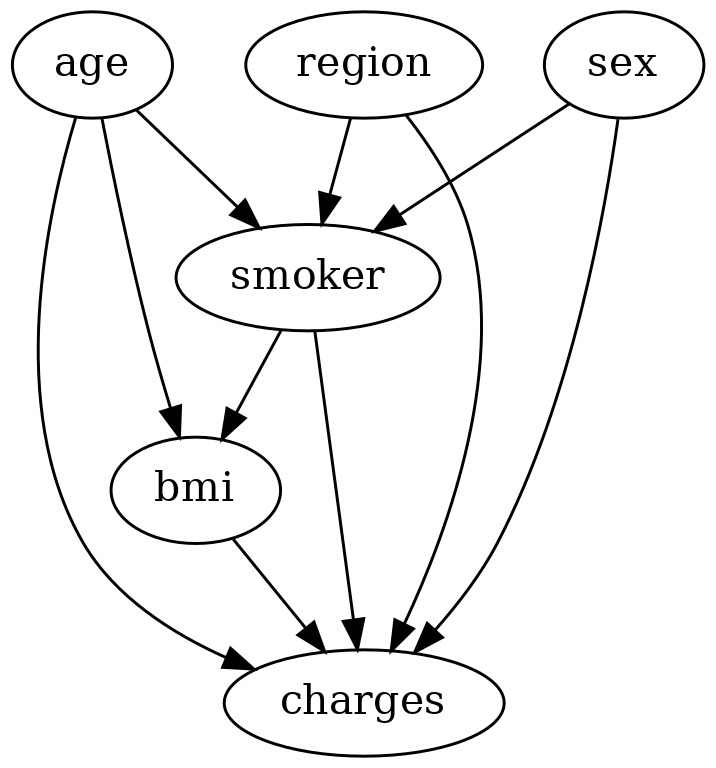

In [7]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [8]:
# Create the estimand
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                               
─────────(E[charges|age,sex,region])
d[smoker]                           
Estimand assumption 1, Unconfoundedness: If U→{smoker} and U→charges then P(charges|smoker,age,sex,region,U) = P(charges|smoker,age,sex,region)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [9]:
# Estimate the effect
causal_estimate = model.estimate_effect(identified_estimand,
        #method_name="backdoor.distance_matching",
        method_name="backdoor.propensity_score_stratification",
        target_units="ate")
        #method_params={'distance_metric':"minkowski", 'p':2})
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

propensity_score_stratification


/home/siddhya/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                               
─────────(E[charges|age,sex,region])
d[smoker]                           
Estimand assumption 1, Unconfoundedness: If U→{smoker} and U→charges then P(charges|smoker,age,sex,region,U) = P(charges|smoker,age,sex,region)

## Realized estimand
b: charges~smoker+age+sex+region
Target units: ate

## Estimate
Mean value: 24018.64839548832

Causal Estimate is 24018.64839548832


In [10]:
# Refute 1
refute_estimate = model.refute_estimate(identified_estimand, causal_estimate,
                                method_name="random_common_cause")
print(refute_estimate)
# The old and new effects are not very far off. So that's good. Not sure what the p value signifies here.

/home/siddhya/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/siddhya/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/siddhya/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/siddhya/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

Refute: Add a random common cause
Estimated effect:24018.64839548832
New effect:23876.567726432964
p value:0.6599999999999999



In [11]:
#Refute 2
refute_estimate = model.refute_estimate(identified_estimand, causal_estimate,
                                method_name="placebo_treatment_refuter")
print(refute_estimate)
# New effect are drastically lower. Which indicates that when the actual treatment is replace by a placebo
# no effect is observed on the treated variable. Which is good.

/home/siddhya/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/siddhya/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/siddhya/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/siddhya/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

Refute: Use a Placebo Treatment
Estimated effect:24018.64839548832
New effect:104.23583516972985
p value:0.82



In [12]:
# Refute 3
refute_estimate = model.refute_estimate(identified_estimand, causal_estimate,
                                method_name="data_subset_refuter")
print(refute_estimate)
# The old and new effects are not very far off. So that's good. Not sure what the p value signifies here.

/home/siddhya/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/siddhya/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/siddhya/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/siddhya/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

Refute: Use a subset of data
Estimated effect:24018.64839548832
New effect:23814.375112541635
p value:0.6399999999999999



Thus it looks like smoking does causally affect your hospital bills.